In [ ]:
!pip install fabio
import fabio
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 13.6 MB/s eta 0:00:00


In [ ]:
def view_cbf(file_path):
    try:
        # Load the .cbf file
        image = fabio.open(file_path)

        # Get the image data
        data = image.data

        # Calculate dimensions
        height, width = data.shape

        # Calculate the center
        center_x = width // 2
        center_y = height // 2

        # Number of color channels
        num_color_channels = 1  # Assuming .cbf files have single-channel data

        # Calculate statistics
        mean_value = np.mean(data)
        std_dev = np.std(data)

        # Print the data and details
        print("\nData:")
        print(data)
        print("\nDimensions (width x height):", width, "x", height)
        print("Center (x, y):", center_x, ",", center_y)
        print("Number of color channels:", num_color_channels)
        print("Mean pixel value:", mean_value)
        print("Standard deviation of pixel values:", std_dev)

        return data, width, height, center_x, center_y, num_color_channels, mean_value, std_dev

    except Exception as e:
        print("Error:", e)
        return None, None, None, None, None, None, None, None

In [ ]:
def convert_cbf_to_png(cbf_file_path, png_file_path):
    try:
        # Load the .cbf file
        image = fabio.open(cbf_file_path)
        image_data = image.data

        print(f"image_data.shape: {image_data.shape}")
        print(f"max: {np.max(image_data)} min: {np.min(image_data)} non-zeros: {np.count_nonzero(image_data)}")

        # Min-max normalization on an array of image data, followed by scaling the result to a range suitable for image data formats (optional, depending on your image data range)
        # Step 1: Shifting the lower bound of the dataset to zero (numerator).
        # Step 2: The maximum value represents the new range of the data (denominator).
        # Step 3: Division scales the adjusted data such that the highest value now becomes 1. The effect is that all pixel values in the image are rescaled to a range 0-1
        # Step 4: Multiplying the normalized data (which ranges from 0 to 1) by 255 changes the range from [0, 1] to [0, 255]
        normalized_image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data)) * 255
        normalized_image_data = normalized_image_data.astype(np.uint8)

        print(f"normalized_image_data.shape: {normalized_image_data.shape}")
        print(f"max: {np.max(normalized_image_data)} min: {np.min(normalized_image_data)} non-zeros: {np.count_nonzero(normalized_image_data)}")

        # Get indices of non-zero elements
        non_zero_indices = np.nonzero(normalized_image_data)
        non_zero_images = normalized_image_data
        # print("Indices of non-zero elements:", non_zero_indices)
        print("Non-zero elements:", non_zero_images[non_zero_indices])

        # Save the image data as a .png file
        img = Image.fromarray(normalized_image_data)
        img.save(png_file_path, format='PNG')
        print(f"Converted {cbf_file_path} to {png_file_path} successfully.")
    except Exception as e:
        print(f"Error converting {cbf_file_path}: {e}")

In [ ]:
def show_png(png_file_path):
    try:
        img = Image.open(png_file_path)
        plt.figure(figsize=(10,10))
        plt.imshow(img, cmap='gray_r', origin='upper', vmin=0, vmax=50)
        plt.axis('off')  # Hide axes
        plt.title('Converted PNG Image')
        plt.show()
    except Exception as e:
        print(f"Error displaying {png_file_path}: {e}")

In [ ]:
def batch_process_cbf_to_png_and_resize(input_directory, output_directory, size=(200, 200)):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(input_directory):
        if filename.endswith(".cbf"):
            cbf_file_path = os.path.join(input_directory, filename)
            png_file_name = filename.replace(".cbf", ".png")
            png_file_path = os.path.join(output_directory, png_file_name)
            resized_png_file_path = os.path.join(output_directory, f"resized_{png_file_name}")

            # Convert the .cbf file to .png
            convert_cbf_to_png(cbf_file_path, png_file_path)

In [ ]:
def process_image(png_file_path, result_path):
    try:
        # Load the converted .png image
        image = cv2.imread(png_file_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image is loaded correctly
        if image is None:
            raise Exception("Could not load image.")

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(image, (5, 5), 0)

        # Use the Canny edge detection algorithm to detect edges
        edges = cv2.Canny(blurred, threshold1=50, threshold2=150, apertureSize=3)

        # Find contours based on the detected edges
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create a copy of the original image to draw contours
        contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # Draw the contours on the image
        cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

        # Save the resulting image with detected contours
        cv2.imwrite(result_path, contour_image)
        print(f"Contours detected and saved to {result_path}")

        # Convert from BGR to RGB (since OpenCV uses BGR by default but matplotlib expects RGB)
        contour_image_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)

        # Display the image using matplotlib
        plt.figure(figsize=(10,10))
        plt.imshow(contour_image_rgb)
        plt.title('Contour Image')
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.show()
    except Exception as e:
        print(f"Error processing image: {e}")

In [ ]:
def plot_histogram(data):
    try:
        # Plot the histogram of pixel values
        plt.hist(data.ravel(), bins=256, range=(data.min(), data.max()), density=True)
        plt.title('Pixel Value Distribution')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.show()
    except Exception as e:
        print("Error plotting histogram:", e)

In [ ]:
# File paths
cbf_file_path = 'snap_0_00012.cbf'
png_file_path = 'snap_0_00012.png'
result_path = 'contours_detected.png'

# Convert .cbf to .png and process the image
convert_cbf_to_png(cbf_file_path, png_file_path)

image_data.shape: (3262, 3108)
max: 81471 min: -1 non-zeros: 10138295
normalized_image_data.shape: (3262, 3108)
max: 255 min: 0 non-zeros: 9465218
Non-zero elements: [1 1 1 ... 1 1 1]
Converted snap_0_00012.cbf to snap_0_00012.png successfully.


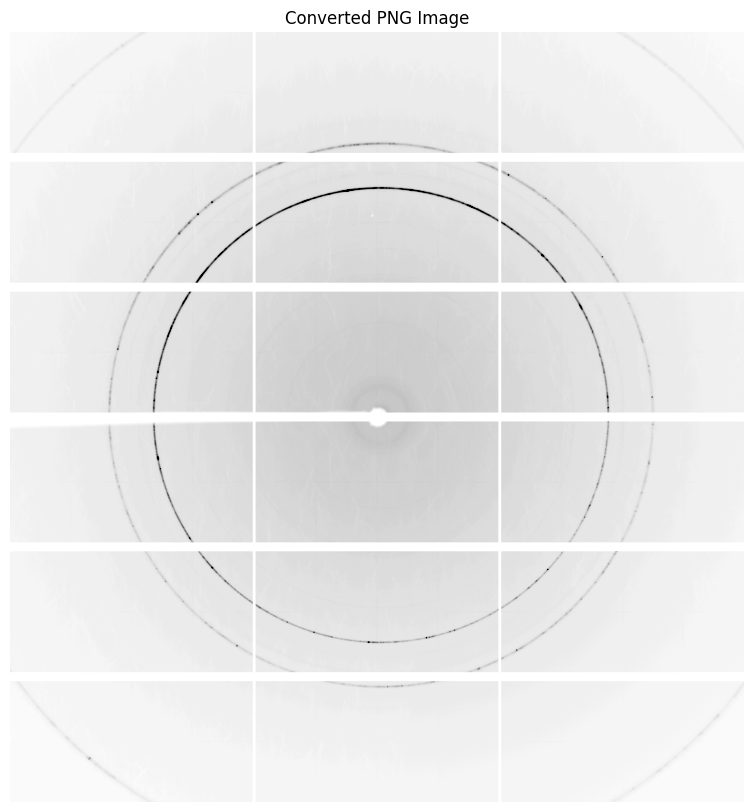

In [ ]:
show_png(png_file_path)

Contours detected and saved to contours_detected.png


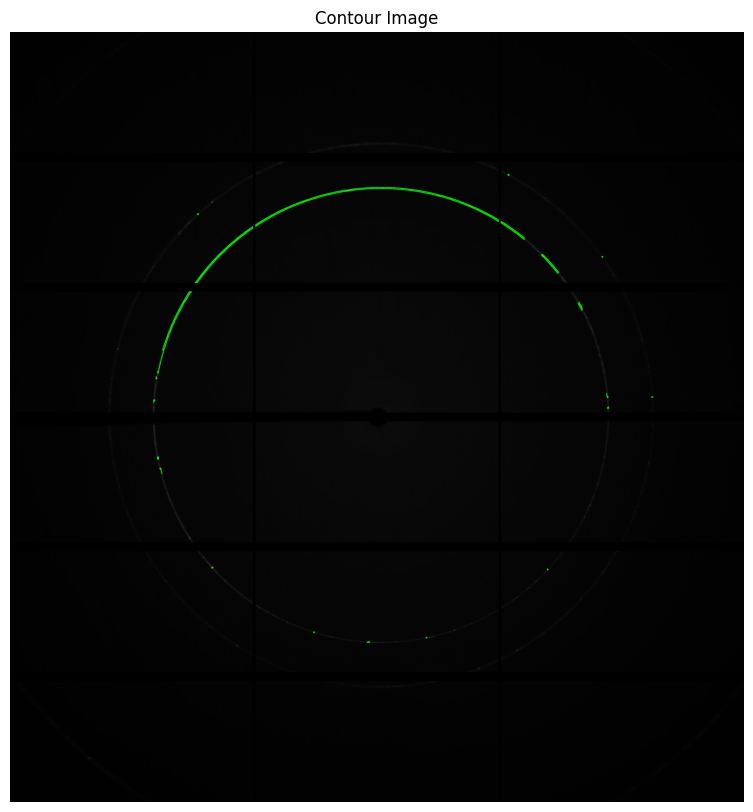

In [ ]:
if png_file_path is not None:
    process_image(png_file_path, result_path)

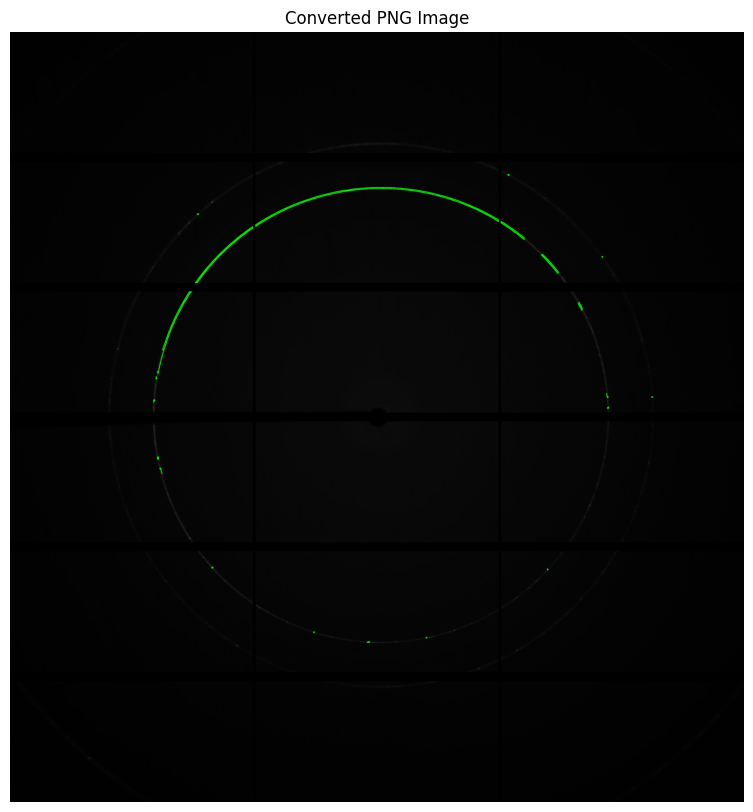

In [ ]:
show_png(result_path)